In [1]:
# set cwd and solver
import os
import cobra
cobra.Configuration().solver = "gurobi"
os.chdir('C:/Users/prins/GitHub/Human1_RPE-PR') 

In [2]:
# load all models in \cs_mods\July2023 folder by cycling through names
from cobra.io import read_sbml_model    
from pathlib import Path
import pandas as pd

# do not change directory but still go to the folder with the models
folder = Path().cwd() / "cs_mods" / "July2023"
model_list = []
for file in folder.glob("*.xml"):  
    model = read_sbml_model(file)
    model.id = file.stem # remove .xml 
    model.name = file.stem # remove .xml
    model_list.append(model)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-03


No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized


In [3]:
# load old combined RPE_PR models
mod_RPE_PR = read_sbml_model(Path().cwd() / "models" / "mod_RPE_PR.xml")
mod_RPE_PR.id = 'RPE_PR_old'
mod_RPE_PR.name = 'RPE_PR_old'
mod_Human1_Human1 = read_sbml_model(Path().cwd() / "models" /  "mod_Human1_Human1.xml")
mod_Human1_Human1.id = 'RPE_PR_control_old'
mod_Human1_Human1.name = 'RPE_PR_control_old'
mod = read_sbml_model(Path().cwd() / 'models/Human-GEM.xml')
mod.id = 'Human1_old'
mod.name = 'Human1_old'

# add old models to model_list
model_list = model_list + [mod,mod_RPE_PR]

# check out model_list
model_list

[<Model Human-GEM_28062023 at 0x194bd5454e0>,
 <Model mod_RPE_PRcone_Liang at 0x194c61fcb20>,
 <Model mod_RPE_PRcone_Liang_singlePR at 0x1948889b340>,
 <Model mod_RPE_PRcone_Liang_singleRPE at 0x194937870a0>,
 <Model mod_RPE_PRcone_Lukowski at 0x194a15ab7f0>,
 <Model mod_RPE_PRcone_Lukowski_singlePR at 0x194a5553c70>,
 <Model mod_RPE_PRcone_Lukowski_singleRPE at 0x194acd4be50>,
 <Model mod_RPE_PRcontrol at 0x19503023520>,
 <Model mod_RPE_PRrod_Liang at 0x194aac4b190>,
 <Model mod_RPE_PRrod_Liang_singlePR at 0x19518dbc100>,
 <Model mod_RPE_PRrod_Liang_singleRPE at 0x19561c9f6d0>,
 <Model mod_RPE_PRrod_Lukowski at 0x195675a27d0>,
 <Model mod_RPE_PRrod_Lukowski_singlePR at 0x1956fc43670>,
 <Model mod_RPE_PRrod_Lukowski_singleRPE at 0x195716e78b0>,
 <Model Human1_old at 0x1958f037a00>,
 <Model RPE_PR_old at 0x194b5375f00>]

In [4]:
# modify models
# load blood exchange bounds

# for all models in the list set objective function (ATP hydrolysis, in PR for combined models)
for m in model_list:
    if 'MAR03964_PR' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_PR'
    elif 'MAR03964_RPE' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_RPE'
    elif 'MAR03964' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964'
    else:
        print('no ATP hydrolysis reaction (MAR03964) in model: ' + m.id)

# list combined and single models
combined_models = [m for m in model_list if 'single' not in m.id and 'Human' not in m.id]
single_models = [m for m in model_list if 'single' in m.id]
Human1_models = [m for m in model_list if 'Human' in m.id]

# close PR exchange in combined models and open RPE exchange (efflux)
for m in combined_models:
    for r in [r for r in m.reactions if len(r.products) == 0 ]:           # close all exchange reactions
        r.bounds=(0,0)
    for r in [r for r in m.reactions if len(r.products) == 0 if '_RPE' in r.id]:           # open efflux for RPE exchange reactions
        r.bounds=(0,1000) 

# only allow efflux exchange in single models
for m in single_models:
    for r in [r for r in m.reactions if len(r.products) == 0 ]:           # close all exchange reactions
        r.bounds=(0,1000)

# for Human1 models, open efflux
for m in [m for m in model_list if 'Human' in m.id]:
    for r in [r for r in m.reactions if len(r.products) == 0]:           # open efflux for RPE exchange reactions
        r.bounds=(0,1000)

In [5]:
# set exchange bounds for blood
from src.modify_model import set_exchange_bounds
ex_bounds = {'MAR09048':(-3.51,1000),'MAR09034':(-4.18,1000),'MAR09135':(7.25,1000)}
# MAR09048: oxygen
# MAR09034: glucose
# MAR09135: lactate

results_dict = {}
for m in model_list:
    set_exchange_bounds(m, ex_bounds)
    m.optimize()
    results_dict[m.id] = m.objective.value
df1 = pd.DataFrame(results_dict, index = ['max ATP hydrolysis (pmol/s/mm^2)']).T
df1

,max ATP hydrolysis (pmol/s/mm^2)
Human-GEM_28062023,24.7325
mod_RPE_PRcone_Liang,23.9000
mod_RPE_PRcone_Liang_singlePR,11.1350
mod_RPE_PRcone_Liang_singleRPE,23.9000
mod_RPE_PRcone_Lukowski,24.7325
mod_RPE_PRcone_Lukowski_singlePR,22.2350
mod_RPE_PRcone_Lukowski_singleRPE,23.9000
mod_RPE_PRcontrol,24.7325
mod_RPE_PRrod_Liang,23.9000
mod_RPE_PRrod_Liang_singlePR,13.9100


In [6]:
def create_stepwise_tuples(start,stop,step):
        """
        this function creates a list of tuples with the same start and stop values, but with a stepwise increase in the values
        """
        import numpy as np
        return [(i,i) for i in np.arange(start,stop+step,step)]
from src.modify_model import create_permutation_dicts


In [7]:
# set objective function oxygen exchange

for m in model_list:
    if 'MAR09048_PR' in [r.id for r in m.reactions]:
        m.objective = 'MAR09048_PR'
    elif 'MAR09048_RPE' in [r.id for r in m.reactions]:
        m.objective = 'MAR09048_RPE'
    elif 'MAR09048_eRPE_PR' in [r.id for r in m.reactions]:
        m.objective = 'MAR09048_eRPE_PR'
    elif 'MAR09048' in [r.id for r in m.reactions]:
        m.objective = 'MAR09048'
    else:
        print('no oxygen exchange reaction (MAR09048) in model: ' + m.id)

In [8]:
# FIX ATP hydrolysis, in PR for combined models) to CK values for rod-dominated tissues at night (26.56 pmol/s/mm2)
for m in model_list:
    if 'MAR03964_PR' in [r.id for r in m.reactions]:
        m.reactions.get_by_id('MAR03964_PR').bounds = (26.56, 26.56)
    elif 'MAR03964_RPE' in [r.id for r in m.reactions]:
        m.reactions.get_by_id('MAR03964_RPE').bounds = (26.56, 26.56)
    elif 'MAR03964' in [r.id for r in m.reactions]:
        m.reactions.get_by_id('MAR03964').bounds = (26.56, 26.56)
    else:
        print('no ATP hydrolysis reaction (MAR03964) in model: ' + m.id)

In [9]:
bounds_oxygen = [(-1000,1000)]
bounds_glucose = create_stepwise_tuples(-10,0,2)
bounds_lactate = create_stepwise_tuples(0,10,2)
ex_bounds = {'MAR09034':bounds_glucose,\
                'MAR09048':bounds_oxygen,\
                'MAR09135':bounds_lactate}
ex_labels = {'glucose':bounds_glucose,\
                'oxygen':bounds_oxygen,\
                'lactate':bounds_lactate}
bounds = create_permutation_dicts(ex_bounds)
labels = create_permutation_dicts(ex_labels)

In [10]:
import warnings
df = pd.DataFrame()
results_dict = {}
for i in range(len(bounds)):
    b = bounds[i]
    l = labels[i]
    for m in model_list:
        warning_filter = 'Solver status is \'infeasible\'' # define filter for specific warning message
        warnings.filterwarnings('ignore', message=warning_filter)     # filter out specific warning message
        set_exchange_bounds(m, b)
        m.optimize()
        results_dict[m.id] = m.objective.value
    df_i = pd.DataFrame(results_dict, index = [str(labels[i]) + ' min oxygen exchange from CC (pmol/s/mm^2)']).T
    df = pd.concat([df,df_i],axis=1)

# lactate and glucose steps (index)
glucose_bounds_df = pd.DataFrame([l['glucose'] for l in labels]).transpose()
lactate_bounds_df = pd.DataFrame([l['lactate'] for l in labels]).transpose()

glucose_bounds_df.index = ['glucose min bound','glucose max bound']
lactate_bounds_df.index = ['lactate min bound','lactate max bound']
df = pd.concat([glucose_bounds_df,lactate_bounds_df,df.transpose().reset_index().transpose()],axis=0)

# create results/heatmaps/Human-GEM_28062023 in user folder
heatmap_folder = os.path.join(os.path.expanduser('~'), 'results', 'heatmaps', 'optimise_oxygen_exchange')
if not os.path.exists(heatmap_folder):
    os.makedirs(heatmap_folder)

# save heatmap_df as excel in results/heatmaps/Human-GEM_28062023
df.to_excel(os.path.join(heatmap_folder, 'optimise_ox_exchange_different_models.xlsx'))

In [11]:
bounds_oxygen = [(-1000,1000)]
bounds_glucose = create_stepwise_tuples(-5,-3.5,.1)
bounds_lactate = create_stepwise_tuples(6,9,.1)
# round numbers to 1 decimal place in tuple list
bounds_glucose = [tuple([round(num,1) for num in tup]) for tup in bounds_glucose]
bounds_lactate = [tuple([round(num,1) for num in tup]) for tup in bounds_lactate]

ex_bounds = {'MAR09034':bounds_glucose,\
                'MAR09048':bounds_oxygen,\
                'MAR09135':bounds_lactate}
ex_labels = {'glucose':bounds_glucose,\
                'oxygen':bounds_oxygen,\
                'lactate':bounds_lactate}
bounds = create_permutation_dicts(ex_bounds)
labels = create_permutation_dicts(ex_labels)

df = pd.DataFrame()
results_dict = {}
for i in range(len(bounds)):
    b = bounds[i]
    l = labels[i]
    for m in [model_list[0]]:
        warning_filter = 'Solver status is \'infeasible\'' # define filter for specific warning message
        warnings.filterwarnings('ignore', message=warning_filter)     # filter out specific warning message
        set_exchange_bounds(m, b)
        m.optimize()
        results_dict[m.id] = m.objective.value
    df_i = pd.DataFrame(results_dict, index = [str(labels[i]) + ' min oxygen exchange from CC (pmol/s/mm^2)']).T
    df = pd.concat([df,df_i],axis=1)

# lactate and glucose steps (index)
glucose_bounds_df = pd.DataFrame([l['glucose'] for l in labels]).transpose()
lactate_bounds_df = pd.DataFrame([l['lactate'] for l in labels]).transpose()

glucose_bounds_df.index = ['glucose min bound','glucose max bound']
lactate_bounds_df.index = ['lactate min bound','lactate max bound']

gluc_lac_df = pd.concat([glucose_bounds_df,lactate_bounds_df,df.transpose().reset_index().transpose()],axis=0)

heatmap_df = gluc_lac_df.transpose()[['glucose min bound', 'lactate min bound', 'Human-GEM_28062023']].astype(float) # select column 'glucose min bound' and 'lactate min bound' and 'Human-GEM_28062023' 
heatmap_df = heatmap_df.pivot(index='glucose min bound', columns='lactate min bound', values='Human-GEM_28062023') # prepare data for heatmap (pivot)

# create results/heatmaps/Human-GEM_28062023 in user folder
heatmap_folder = os.path.join(os.path.expanduser('~'), 'results', 'heatmaps', 'Human-GEM_28062023')
if not os.path.exists(heatmap_folder):
    os.makedirs(heatmap_folder)

# save heatmap_df as excel in results/heatmaps/Human-GEM_28062023
heatmap_df.to_excel(os.path.join(heatmap_folder, 'heatmap_optimise_oxygen_exchange_Human-GEM_28062023.xlsx'))


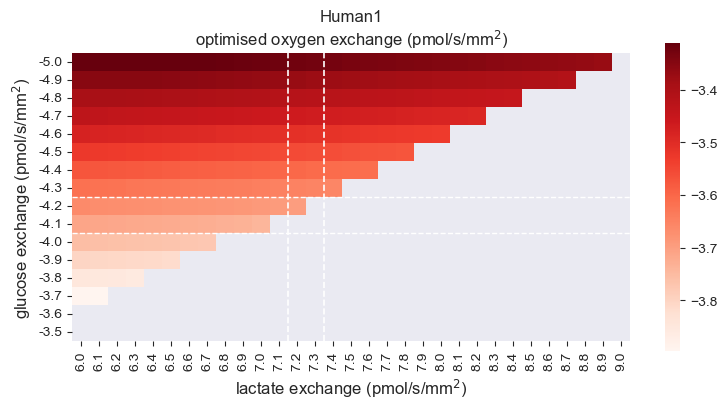

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# figure size
fig = plt.figure(figsize=(9,4))
# reset sns style darkgrid with major xticks
sns.set_style('darkgrid', \
    {'xtick.bottom': True, 'xtick.major.pad': 1.0, 'xtick.major.size': 3.0, 'xtick.major.width': 1.0,\
     'ytick.left': True, 'ytick.major.pad': 1.0, 'ytick.major.size': 3.0, 'ytick.major.width': 1.0})

# plot heatmap
sns.heatmap(heatmap_df,cmap='Reds')

# turn x ticks 90 degrees
plt.xticks(rotation=90)

# draw lines at xtick labels '7.2' and '7.3'
xtick_labels, xtick_positions = plt.xticks() # get xtick labels and positions
xpos1 = [t.get_position()[0]-.5 for t in xtick_positions if t.get_text() == '7.2']
xpos2 = [t.get_position()[0]+.5 for t in xtick_positions if t.get_text() == '7.3']
plt.axvline(x=xpos1, color='white', linestyle='--',linewidth=1.2)
plt.axvline(x=xpos2, color='white', linestyle='--',linewidth=1.2)

# draw lines at ytick labels -4.1 and -4.2
ytick_labels, ytick_positions = plt.yticks() # get ytick labels and positions
ypos1 = [t.get_position()[1]+.5 for t in ytick_positions if t.get_text() == '-4.1']
ypos2 = [t.get_position()[1]-.5 for t in ytick_positions if t.get_text() == '-4.2']
plt.axhline(y=ypos1, color='white', linestyle='--',linewidth=1)
plt.axhline(y=ypos2, color='white', linestyle='--',linewidth=1)

# make all squares perfectly squared
plt.gca().set_aspect('equal', adjustable='box')

# change x and y axis labels
plt.xlabel('lactate exchange (pmol/s/mm$^2$)', fontsize=12)
plt.ylabel('glucose exchange (pmol/s/mm$^2$)', fontsize=12)

# add plt title
plt.title('Human1\noptimised oxygen exchange (pmol/s/mm$^2$)')

plt.show()

# save fig in results heatmaps folder 'heatmap_folder'
fig.savefig(heatmap_folder + '/heatmap_Human1_optimised_oxygen_exchange.png', bbox_inches='tight', dpi=300)


In [13]:
model_list[-5]

Name,mod_RPE_PRrod_Lukowski
Memory address,195675a27d0
Number of metabolites,10678
Number of reactions,14592
Number of genes,2188
Number of groups,149
Objective expression,1.0*MAR09048_RPE - 1.0*MAR09048_RPE_reverse_41024
Compartments,"c_RPE, r_RPE, e_RPE, m_RPE, x_RPE, g_RPE, l_RPE, n_RPE, i_RPE, e_RPE_PR, c_PR, x_PR, m_PR, g_PR, r_PR, l_PR, i_PR"


In [14]:

############################
# mod_RPE_PRrod_Lukowski ###
############################


bounds_oxygen = [(-1000,1000)]
bounds_glucose = create_stepwise_tuples(-5,-3.5,.1)
bounds_lactate = create_stepwise_tuples(6,9,.1)
# round numbers to 1 decimal place in tuple list
bounds_glucose = [tuple([round(num,1) for num in tup]) for tup in bounds_glucose]
bounds_lactate = [tuple([round(num,1) for num in tup]) for tup in bounds_lactate]

ex_bounds = {'MAR09034':bounds_glucose,\
                'MAR09048':bounds_oxygen,\
                'MAR09135':bounds_lactate}
ex_labels = {'glucose':bounds_glucose,\
                'oxygen':bounds_oxygen,\
                'lactate':bounds_lactate}
bounds = create_permutation_dicts(ex_bounds)
labels = create_permutation_dicts(ex_labels)

df = pd.DataFrame()
results_dict = {}
for i in range(len(bounds)):
    b = bounds[i]
    l = labels[i]
    for m in [model_list[-5]]:
        warning_filter = 'Solver status is \'infeasible\'' # define filter for specific warning message
        warnings.filterwarnings('ignore', message=warning_filter)     # filter out specific warning message
        set_exchange_bounds(m, b)
        m.optimize()
        results_dict[m.id] = m.objective.value
    df_i = pd.DataFrame(results_dict, index = [str(labels[i]) + ' min oxygen exchange from CC (pmol/s/mm^2)']).T
    df = pd.concat([df,df_i],axis=1)

# lactate and glucose steps (index)
glucose_bounds_df = pd.DataFrame([l['glucose'] for l in labels]).transpose()
lactate_bounds_df = pd.DataFrame([l['lactate'] for l in labels]).transpose()

glucose_bounds_df.index = ['glucose min bound','glucose max bound']
lactate_bounds_df.index = ['lactate min bound','lactate max bound']

gluc_lac_df = pd.concat([glucose_bounds_df,lactate_bounds_df,df.transpose().reset_index().transpose()],axis=0)

# select column 'glucose min bound' and 'lactate min bound' and 'Human-GEM_28062023' 
heatmap_df = gluc_lac_df.transpose()[['glucose min bound', 'lactate min bound', 'mod_RPE_PRrod_Lukowski']].astype(float) # make heatmap with glucose min bound and lactate min bound as x and y axis
heatmap_df = heatmap_df.pivot(index='glucose min bound', columns='lactate min bound', values='mod_RPE_PRrod_Lukowski') # prepare data for heatmap (pivot)

# create results/heatmaps/mod_RPE_PRrod_Lukowski in user folder
heatmap_folder = os.path.join(os.path.expanduser('~'), 'results', 'heatmaps', 'mod_RPE_PRrod_Lukowski')
if not os.path.exists(heatmap_folder):
    os.makedirs(heatmap_folder)

# save heatmap_df as excel in results/heatmaps/mod_RPE_PRrod_Lukowski
heatmap_df.to_excel(os.path.join(heatmap_folder, 'heatmap_optimise_oxygen_exchange_mod_RPE_PRrod_Lukowski.xlsx'))


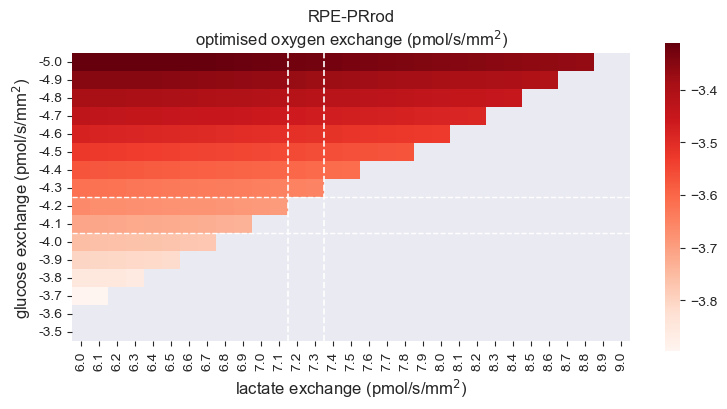

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
# figure size
fig = plt.figure(figsize=(9,4))
# reset sns style darkgrid with major xticks
sns.set_style('darkgrid', \
    {'xtick.bottom': True, 'xtick.major.pad': 1.0, 'xtick.major.size': 3.0, 'xtick.major.width': 1.0,\
     'ytick.left': True, 'ytick.major.pad': 1.0, 'ytick.major.size': 3.0, 'ytick.major.width': 1.0})

# plot heatmap
sns.heatmap(heatmap_df,cmap='Reds')

# turn x ticks 90 degrees
plt.xticks(rotation=90)

# draw lines at xtick labels '7.2' and '7.3'
xtick_labels, xtick_positions = plt.xticks() # get xtick labels and positions
xpos1 = [t.get_position()[0]-.5 for t in xtick_positions if t.get_text() == '7.2']
xpos2 = [t.get_position()[0]+.5 for t in xtick_positions if t.get_text() == '7.3']
plt.axvline(x=xpos1, color='white', linestyle='--',linewidth=1.2)
plt.axvline(x=xpos2, color='white', linestyle='--',linewidth=1.2)

# draw lines at ytick labels -4.1 and -4.2
ytick_labels, ytick_positions = plt.yticks() # get ytick labels and positions
ypos1 = [t.get_position()[1]+.5 for t in ytick_positions if t.get_text() == '-4.1']
ypos2 = [t.get_position()[1]-.5 for t in ytick_positions if t.get_text() == '-4.2']
plt.axhline(y=ypos1, color='white', linestyle='--',linewidth=1)
plt.axhline(y=ypos2, color='white', linestyle='--',linewidth=1)

# make all squares perfectly squared
plt.gca().set_aspect('equal', adjustable='box')

# change x and y axis labels
plt.xlabel('lactate exchange (pmol/s/mm$^2$)', fontsize=12)
plt.ylabel('glucose exchange (pmol/s/mm$^2$)', fontsize=12)

# add plt title
plt.title('RPE-PRrod\noptimised oxygen exchange (pmol/s/mm$^2$)')
plt.show()

# save fig in results heatmaps folder 'heatmap_folder'
fig.savefig(heatmap_folder + '/heatmap_RPE_PRrod_optimised_oxygen_exchange.png', bbox_inches='tight', dpi=300)
